In [2]:
import proj2_helpers

import pandas as pd

import numpy as np

from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

from surprise import Reader

In [34]:
# Grid to find params for SurpriseSVD

reader = Reader(line_format='user item rating', sep='\t')

data = Dataset.load_from_file('data/data.txt', reader=reader)

trainset, testset = train_test_split(data, test_size=.1)


for is_baised in [True, False]:
    for epochs in [10, 50, 75]:
        for reg in [.02, .05, .1]:
            for lr in [.002, .005, .01]:    
                
                # MSE: 0.824858274846777	(True, 75, 0.1, 0.005)                
                algo = SVD(n_factors=20, biased=is_baised, n_epochs=epochs, reg_all=reg, lr_all = lr)

                # Train the algorithm on the trainset, and predict ratings for the testset
                fit_result = algo.fit(trainset)

                predictions = algo.test(testset)

                # Then compute RMSE
                rmse = accuracy.rmse(predictions, False)
                
                print('MSE: ' + str(rmse**2) + '\t' + str((is_baised,epochs,reg,lr)))


MSE: 0.9110818734479287	(True, 10, 0.02, 0.002)
MSE: 0.8873039599183014	(True, 10, 0.02, 0.005)
MSE: 0.869710228833948	(True, 10, 0.02, 0.01)
MSE: 0.9122301120008274	(True, 10, 0.05, 0.002)
MSE: 0.8874433829499113	(True, 10, 0.05, 0.005)
MSE: 0.8727759187983799	(True, 10, 0.05, 0.01)
MSE: 0.9140941278009074	(True, 10, 0.1, 0.002)
MSE: 0.8917678512349528	(True, 10, 0.1, 0.005)
MSE: 0.8820398617830039	(True, 10, 0.1, 0.01)
MSE: 0.8641576378293937	(True, 50, 0.02, 0.002)
MSE: 0.9136459605329497	(True, 50, 0.02, 0.005)
MSE: 0.9799357505301536	(True, 50, 0.02, 0.01)
MSE: 0.8684089064768963	(True, 50, 0.05, 0.002)
MSE: 0.8419377678838339	(True, 50, 0.05, 0.005)
MSE: 0.87478381556768	(True, 50, 0.05, 0.01)
MSE: 0.8796983156731467	(True, 50, 0.1, 0.002)
MSE: 0.8392015920800492	(True, 50, 0.1, 0.005)
MSE: 0.8206694046406434	(True, 50, 0.1, 0.01)
MSE: 0.8648303628697427	(True, 75, 0.02, 0.002)
MSE: 0.9561149472411297	(True, 75, 0.02, 0.005)
MSE: 1.0352651305178735	(True, 75, 0.02, 0.01)
MSE: 0.8

In [3]:
# Surprise SVD

reader = Reader(line_format='user item rating', sep='\t')
data = Dataset.load_from_file('data/data.txt', reader=reader)
trainset, testset = train_test_split(data, test_size=.02, shuffle=False)

algo = SVD(n_factors=20, biased=True, n_epochs=75, reg_all=0.1, lr_all=0.005)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
rmse_ = accuracy.rmse(predictions, False)
print('MSE: ' + str(rmse_*rmse_))


# Check shapes 
print(np.shape(algo.pu))
print(np.shape(algo.qi)) # This does not have the full 1682 because the training set does not have ratings
                         # for all movies. Bug in Surprise Library?
print(np.shape(algo.bu))
print(np.shape(algo.bi))

MSE: 0.8233774138356621
(943, 20)
(1679, 20)
(943,)
(1679,)


In [88]:
# Load data and packages for visualization
from proj2_helpers import *

def generate_proj(V_t, U):
    '''
    Finds the 2D projection of the "V" matrix.
    
    Inputs:
        V_t: the transpose of the V matrix
        
    Outputs:
        The 2D projection of the "V" matrix and transpose of "U"
    '''
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    
    scaler = StandardScaler(with_std=False)
    pca = PCA(n_components=2)
    
    V_t_scale = scaler.fit_transform(V_t)
    U_t_scale = scaler.transform(U)
    V_s = V_t_scale.T
    U_s = U_t_scale.T
    
    pca.fit(V_t_scale)
    print(pca.explained_variance_ratio_)
    A_12 = pca.components_
    
    return np.dot(A_12, V_s), np.dot(A_12, U_s)

def get_genre_ids(movies_df, genre, n=-1):
    '''Gets the first n movie ids of the given genre
    
    Inputs:
        movies_df: pandas dataframe with movie informations, including
        title, average rating, and genre information.
        
        genre: the genre to retrieve the ids for
        
        n: the number of ids to retrieve
        
    Output:
        a numpy array of integers corresponding to the id of the movies
    '''
    return movies_df[movies_df[genre]==1]['Movie Id'][:n]

def plot_proj(proj, movies_df, movie_ids, id_label=None, label_pts=True, suppress=False, box_color='yellow', size=(10, 10)):
    '''
    Plots the movies given by the ids on the 2D projection
    
    Inputs:
        proj: the 2D projection of the factorized "V" matrix. 
        
        movies_df: pandas dataframe with movie informations, including
        title, average rating, and genre information.
        
        movie_ids: numpy array of integers corresponding to the movies to plot.
        
        id_label: the label of the points in the legend. Relevant for multiple 
        datasets. (default = None)
        
        label_pts: boolean of whether to label plotted point with movie titles
        (default = True)
        
        suppress: boolean of whether to initialize and display the plot. To 
        plot multiple plots on the same figure, let suppress=True. (default = False)
        
        box_color: color of shading of the labels (default = yellow)
        
        size: size of the plot
        
    Outputs:
        None.
    '''
    if suppress == False:
        plt.figure(figsize=size)
    
    mask = np.zeros(len(proj[0]), dtype=bool)
    mask[movie_ids-1] = True
    
    x = proj[0][mask]
    y = proj[1][mask]
    
    plt.scatter(x, y, label=id_label)
    if label_pts == True:
        labels = [get_title_from_id(movies_df, movie_id) for movie_id in movie_ids]
        for label, x1, y1 in zip(labels, x, y):
            plt.annotate(
                label,
                xy=(x1, y1), xytext=(-5, 5),
                textcoords='offset points', ha='right', va='bottom'
                ,bbox=dict(boxstyle='round,pad=0.5', fc=box_color, alpha=0.2)
                #,arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
            )
    plt.axis('equal')
    if suppress == False:
        plt.show()

In [119]:
V_s, U_s = generate_proj(algo.qi, algo.pu)

[0.21782221 0.09696388]


In [120]:
data = np.loadtxt('data/data.txt', dtype=int)
movies = pd.read_csv('../data/movies.csv', sep=',', encoding='latin1')

In [121]:
avg = np.zeros(len(movies))
count = np.zeros(len(movies))
for movie_id in movies['Movie Id']:
    inds = (data[:,1] == movie_id)
    avg[movie_id-1] = (np.mean(data[:,2][inds]))
    count[movie_id-1] = np.sum(inds)

movies['Avg'] = avg
movies['Tot'] = count

In [122]:
# Set up dfs
pop_movies = movies.sort_values(by='Tot', ascending=False)
rate_movies = movies.sort_values(by='Avg', ascending=False)

# Set movie loc/IDs
pop_movies_ids = pop_movies['Movie Id'][:10]
rate_movies_ids = rate_movies['Movie Id'][:10]
com_movies_ids = pop_movies[pop_movies['Comedy'] == 1]['Movie Id'][:10]
doc_movies_ids = pop_movies[pop_movies['Documentary'] == 1]['Movie Id'][:10]
hor_movies_ids = pop_movies[pop_movies['Horror'] == 1]['Movie Id'][:10]
rom_movies_ids = pop_movies[pop_movies['Romance'] == 1]['Movie Id'][:10]
rand_movies_ids = rate_movies[rate_movies['Tot'] > 100]['Movie Id'][:10]

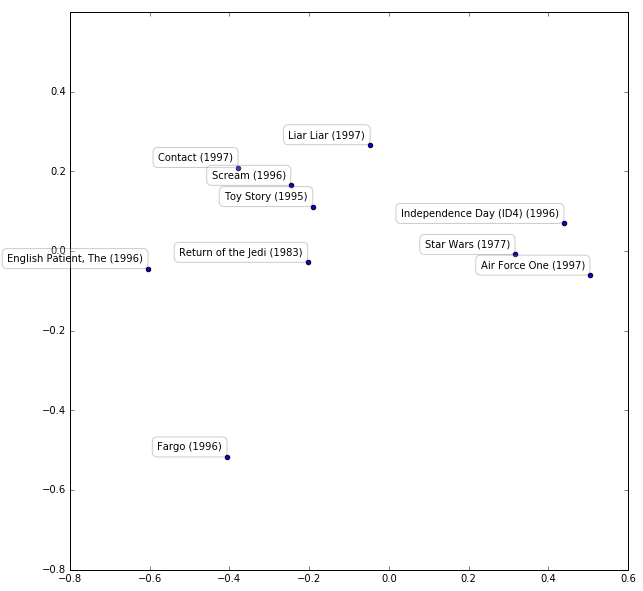

In [123]:
plt.figure(figsize=(15,15))
plot_proj(V_s, movies, pop_movies_ids, id_label='Most Rated', box_color='white', suppress=False)

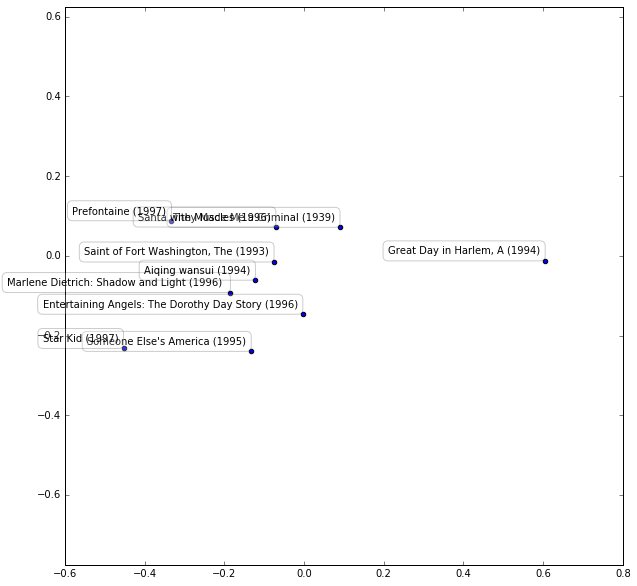

In [124]:
plt.figure(figsize=(15,15))
plot_proj(V_s, movies, rate_movies_ids, id_label='Highest Rated', box_color='white', suppress=False)

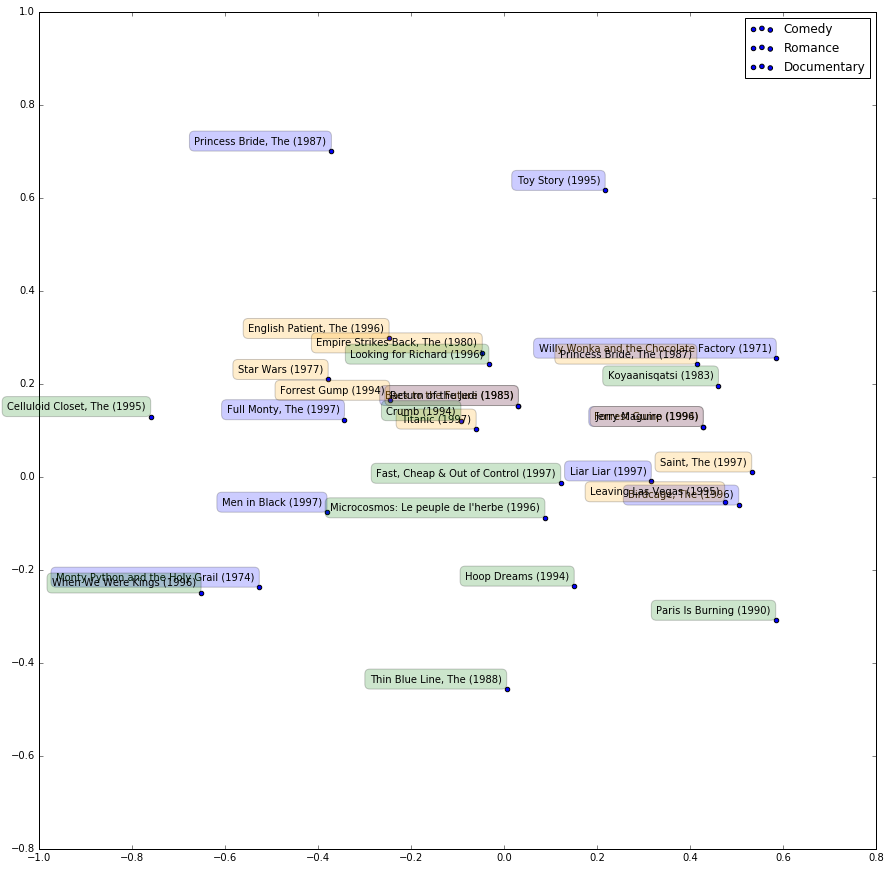

In [125]:
plt.figure(figsize=(15,15))
plot_proj(V_s, movies, com_movies_ids, id_label='Comedy', box_color='blue', suppress=True)
plot_proj(V_s, movies, rom_movies_ids, id_label='Romance', box_color='orange', suppress=True)
plot_proj(V_s, movies, doc_movies_ids, id_label='Documentary', box_color='green', suppress=True)
plt.legend()

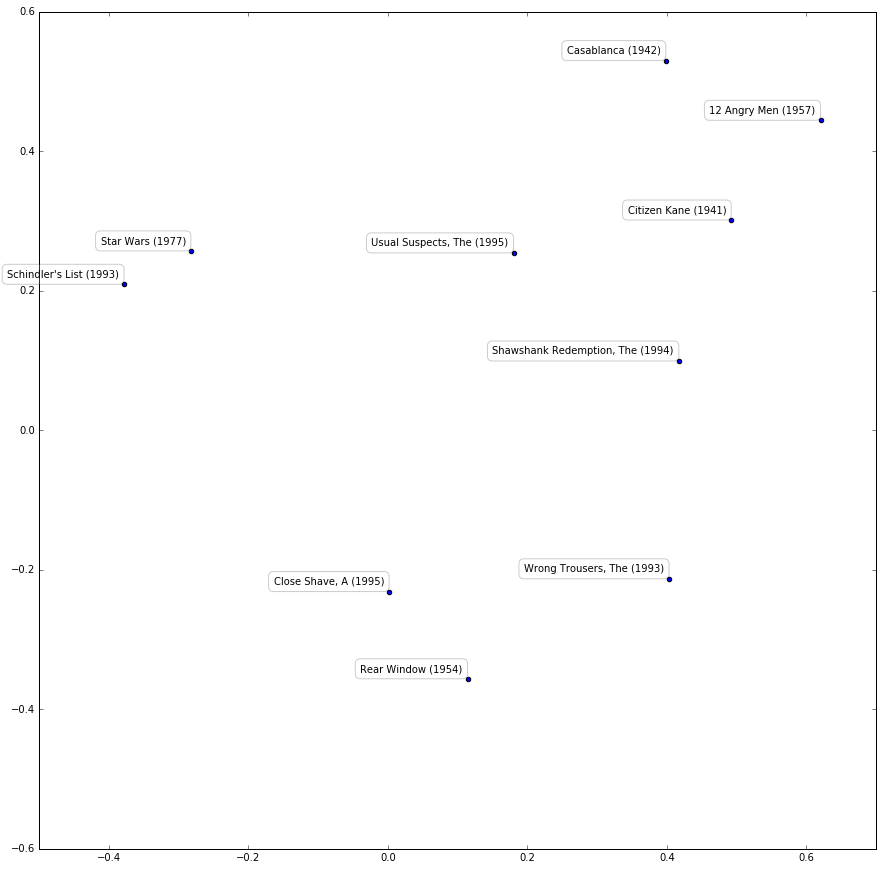

In [126]:
plt.figure(figsize=(15,15))
plot_proj(V_s, movies, rand_movies_ids, id_label='Random', box_color='white', suppress=True)